<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
<img border="0" src="https://www.usinenouvelle.com/mediatheque/3/2/7/000624723_image_600x315.jpg" width="30%"> </td>
<img border="0" src="https://josephsteinberg.com/wp-content/uploads/2020/01/Facial-Recognition.png" width="40%"> </td>
  </tr>
</table> 
</div>
<center><h1> Face Recognition</h1></center>
<br>
<center> Nayel Bettache, Solène Cochennec </center>

## Table of Contents

0. [Introduction](#intro)<br>
1. [Data Analysis](#Data-Analysis) <br>

<a id='intro'></a>
# Introduction 

The aim of the project is to implement various techniques on face recognition, based on two articles "Face Recogniftion by Sparse Representation" (article 1) and "Robust Face Recognition via Sparse Representation" (article 2).



We will firstly select a face database (we only consider a small one for now, and we may extend it after). We will use the Yale face database (http://vision.ucsd.edu/content/yale-face-database) which contains  contains 165 grayscale images in GIF format of 15 individuals. 

There are 11 images per subject, one per different facial expression or configuration: center-light, w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink.

### We start by downloading it into a new folder 

In [3]:
!python import_data.py

=> File saved as data/face_yale.zip


### Unzip the doc & prepare data (no need to run this part if the data is download from github) 

In [149]:
import zipfile

In [150]:
path_zip = path + "/data/face_yale.zip"
directory = "data"
with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(directory)

In [14]:
import os 
import pandas as pd 
from PIL import Image
from glob import glob
import numpy as np 

In [8]:
path = os.getcwd() ## Vérifier que ton os est bien dans le folder "face_recognition"
path

'/Users/solene/Desktop/face_recognition'

In [152]:
collection = path + "/data/yalefaces"
for filename in os.listdir(collection):
    new_name = filename.replace(".","_")
    os.rename(path + "/data/yalefaces/" + str(filename), path + "/data/yalefaces/" + new_name + ".png")


In [153]:
os.remove('data/yalefaces/Readme_txt.png')

### To get one image 

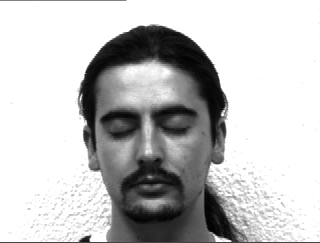

In [15]:
Image.open('data/yalefaces/subject09_sleepy.png')

### Get the database 

In [16]:
imPath = "data/yalefaces"
ls_path = glob(os.path.join(imPath, '*' ))

image_base_empty=[]
label_empty=[]

for file in ls_path: 
    im = np.array(Image.open(file))  ## Put the image into an array
    image_base_empty+=[im]
    label_empty+=[file.split('/')[2].split('_')[0].split('subject')[1]]   
    
image_base = np.array(image_base_empty)
labels = np.array(label_empty)

In [17]:
## We have two elements : images converted to arrays and labels 
labels.shape

(166,)

In [25]:
image_base.shape

(166, 243, 320)

In [18]:
image_base[0]

array([[110, 117, 121, ..., 251, 231, 241],
       [250, 255, 255, ..., 249, 243, 252],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [243, 255, 255, ..., 167, 156, 160],
       [246, 255, 255, ..., 171, 153, 154],
       [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8)

# Preparation to models 

In [20]:
from sklearn.model_selection import train_test_split


In [21]:
ramdom_seed=5

X_train, X_test, Y_train, Y_test = train_test_split(image_base, labels, test_size=0.20, random_state=ramdom_seed)

We separate our database into 2 sets : train (132 elements) and test (34 elements) randomnly. 

In [23]:
X_train.shape

(132, 243, 320)

In [26]:
X_test.shape

(34, 243, 320)